In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
AssetPrice = pd.read_excel('C:/Users/Thinkpad/Desktop/大类资产-细分数据.xlsx').set_index('date').fillna(method='bfill')
AssetReturn = AssetPrice.pct_change().dropna()

In [3]:
AssetReturn = AssetPrice.pct_change().dropna()

In [4]:
AssetList = AssetPrice.columns.tolist()

In [ ]:
'''
回测起止时间设定
'''

In [5]:
start = '2005-02-01'
end = '2019-06-30'

In [6]:
AssetPrice = AssetPrice[(AssetPrice.index<=end) & (AssetPrice.index>=start)]
AssetReturn = AssetReturn[(AssetReturn.index<=end) & (AssetReturn.index>=start)]

In [ ]:
'''
全样本（用于测试，输出一次目标权重）
'''

In [ ]:
'''
秩相关系数信号
'''

In [7]:
RankWindow = 42
AssetReturnMean = AssetReturn.rolling(RankWindow).mean()
AssetReturnStd = AssetReturn.rolling(RankWindow).std()

In [8]:
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

def ComputeRank(df):
    df = df.copy()
    trade_date = df['date'].tolist()[0]
    dfSub = df[AssetList]
    tmpDf = dfSub.T
    tmpcol = tmpDf.columns.tolist()[0]
    tmpDf0 = tmpDf.sort_values(tmpcol,ascending=False)
    tmpDf0[tmpcol] = range(1,len(tmpDf)+1)
    tmpDf1 = tmpDf0.T[AssetList]
    tmpDf1.index = [trade_date]
    return tmpDf1

AssetReturnStdRank = applyParallel(AssetReturnStd.reset_index().groupby('date'),ComputeRank)
AssetReturnMeanRank = applyParallel(AssetReturnMean.reset_index().groupby('date'),ComputeRank)

In [9]:
IterList = []
DateList = AssetReturnMeanRank.index
for date in AssetReturnMeanRank.index:
    MeanRankList = AssetReturnMeanRank.loc[date,:].tolist()
    StdRankList = AssetReturnStdRank.loc[date,:].tolist()
    IterList.append([MeanRankList,StdRankList])

def ComputeCorr(List):
    return np.corrcoef(List[0],List[1])[0,1]
    
RankCorrList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(ComputeCorr)(group) for group in IterList)

In [10]:
RankCorrDf = pd.DataFrame(RankCorrList,index=DateList,columns=['RankCorr'])

In [11]:
threshold = -0.9
RankCorrDf['RankCorrSignal'] = RankCorrDf['RankCorr'].apply(lambda x: 1 if x<threshold else 0)

In [12]:
RankCorrDf['trade_date'] = RankCorrDf.index
RankCorrDf_M_date = RankCorrDf[['trade_date']].apply(lambda x:x.resample('M').last())
RankCorrDf_M = RankCorrDf[['RankCorrSignal']].apply(lambda x:x.resample('M').sum())
RankCorrDf_M.index = RankCorrDf_M_date['trade_date']

In [ ]:
'''
风险平价模型
'''

In [13]:
# 计算协方差矩阵 - 年化
V = AssetReturn.cov()*252

# 组合风险函数，输出 1x1
def PortfolioVar(w,V):
    return np.dot(np.dot(w,V),np.transpose(w))

# 各资产边际风险贡献，输出 Nx1
def RiskContribution(w,V):
    sigma_p = np.sqrt(PortfolioVar(w,V))
    MRC = np.dot(V,np.transpose(w))/sigma_p
    RC = np.multiply(MRC,np.transpose(w))
    return RC

# 风险平价目标函数
def RiskParity(w):
    sigma_p = np.sqrt(PortfolioVar(w,V))
    N = len(w)
    V_w = np.dot(V,np.transpose(w))
    J_list = []
    for i in range(N):
        item_i = w[i]*V_w[i]
        for j in range(N):
            item_j = w[j]*V_w[j]
            J_list.append(np.square(item_j-item_i))
    J = np.sum(J_list)
    return J

# 优化求解目标权重w
def CalculateW(V):
    # 资产数量
    N = len(V)
    # 初始权重
    w0 = [1/N for each in range(N)]
    # 约束
    def WeightConstranit1(w):
        return np.sum(w)-1
    def WeightConstranit2(w):
        return w
    cons = ({'type':'eq','fun':WeightConstranit1},{'type':'ineq','fun':WeightConstranit2})
    optimize_fun = sco.minimize(RiskParity,w0,method='SLSQP',constraints=cons)
    w_best = optimize_fun['x']
    return list(w_best)

In [ ]:
'''
MVO模型
'''

In [88]:
expected_return = 0.06
expected_vol = 0.08

In [74]:
minvol_str = 'MVO 最小化风险 收益%d%%' %(expected_return*100)
maxreturn_str = 'MVO 最大化收益 风险%d%%' %(expected_vol*100)

In [75]:
# 组合风险函数，输出 1x1
def PortfolioVar(w,V):
    return np.dot(np.dot(w,V),np.transpose(w))

# 最大化IR
def max_IR(w):
    sigma_p = PortfolioVar(w,V)
    return -((w*mu.T)[0,0])/np.sqrt(sigma_p)

# 最大化效用
def max_unity(w):
    sigma_p = PortfolioVar(w,V)
    risk_lambda = 2
    return -((w*mu.T)[0,0] - 0.5*risk_lambda*sigma_p)

# 最小化风险
def min_risk(w):
    sigma_p = PortfolioVar(w,V)
    return sigma_p

# 最大化收益
def max_return(w):
    mu_p = (w*mu.T)[0,0]
    return -mu_p

def MVOCalculateW(V):
    # 资产数量
    N = len(V)
    # 初始权重
    w0 = [1/N for each in range(N)]
    # 约束
    def WeightConstranit1(w):
        return np.sum(w)-1
    def WeightConstranit2(w):
        return w-0.001
    def WeightConstranit3(w):
        return (w*mu.T)[0,0]-expected_return
    def WeightConstranit4(w):
        return PortfolioVar(w,V)-expected_vol
    if method == 'MVO 最大化IR':
        cons = ({'type':'eq','fun':WeightConstranit1},{'type':'ineq','fun':WeightConstranit2})
        optimize_fun = sco.minimize(max_IR,w0,method='SLSQP',constraints=cons)
    if method == 'MVO 最大化效用':
        cons = ({'type':'eq','fun':WeightConstranit1},{'type':'ineq','fun':WeightConstranit2})
#         cons = ({'type':'ineq','fun':WeightConstranit2})
        optimize_fun = sco.minimize(max_unity,w0,method='SLSQP',constraints=cons)
    if method == minvol_str:
        cons = ({'type':'eq','fun':WeightConstranit1},{'type':'ineq','fun':WeightConstranit2},{'type':'eq','fun':WeightConstranit3})
        optimize_fun = sco.minimize(min_risk,w0,method='SLSQP',constraints=cons)
    if method == maxreturn_str:
        cons = ({'type':'eq','fun':WeightConstranit1},{'type':'ineq','fun':WeightConstranit2},{'type':'eq','fun':WeightConstranit4})
        optimize_fun = sco.minimize(max_return,w0,method='SLSQP',constraints=cons)
    w_best = optimize_fun['x']
    return list(w_best)

In [ ]:
'''
月度回测 - 函数
'''

In [18]:
### 策略函数
def Strategy(history_trade_data):
    '''
    输入历史行情收益率数据，计算协方差矩阵
    输出所有资产对应目标权重
    '''
    df_ = history_trade_data.copy()
    
    if method == '风险平价':
        w_list = CalculateW(V)
    if method == '等权重':
        w_list = [1/len(V) for each in range(len(V))]
    if method[:3] == 'MVO':
        w_list = MVOCalculateW(V)
    
    expected_stock_weight = (pd.DataFrame(w_list,index=AssetList).T)[AssetList]

    return expected_stock_weight

In [19]:
### 结算函数 - 月度结算
def Clear(df,tol_equity,expected_stock_weight):
    '''
    输入下一个月收益率数据（月初至月末）、结算前净值（初始值为1）、目标权重
    输出下一个月净值序列（月初-月末）
    '''
    df_ = df.copy()
    expected_stock_w = expected_stock_weight.copy()
    
    # 普通结算
    df_ = df_+1
    
    # 初始净值分配到各个资产上，乘以累计相对增长得到净值序列，丢弃首行拼接  
    stock_w = expected_stock_w.apply(lambda x: x*tol_equity*max_position)

    equity_tmp = pd.concat([stock_w,df_],axis=0,sort=False)
    equity_df = equity_tmp.cumprod().sum(axis=1).to_frame('equity_series').iloc[1:,]
    equity_df = equity_df+tol_equity*(1-max_position)
    
    return equity_df, equity_df['equity_series'][-1]

In [112]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

In [129]:
### 风险分散程度计算函数 - 独特函数！
def DRindicator(last_strategy_date,strategy_date,expected_weight_df):
    '''
    last_strategy_date：上一个策略日
    strategy_date：当前策略日
    expected_weight_df：上一期的资产目标权重df
    '''
    last_equity_df = equity_df[(equity_df.index<=strategy_date) & (equity_df.index>=last_strategy_date)]
    last_trade_df = AssetReturn[(AssetReturn.index<=strategy_date) & (AssetReturn.index>=last_strategy_date)]
    
    equity_df_return = last_equity_df.pct_change().dropna()
    sigma_p = equity_df_return.var()
    sigma_i = last_trade_df.var()
    return np.sum(np.multiply(sigma_i.tolist(),expected_weight_df.T[0].tolist()))/sigma_p.values[0]

In [ ]:
'''
月度回测 - 结果
'''

In [130]:
# 获取回测时点
AssetPrice_ = AssetPrice.copy()
AssetPrice_['trade_date'] = AssetPrice_.index
AssetPrice_M = AssetPrice_.apply(lambda x: x.resample('M').last())
StrategyDateList = AssetPrice_M['trade_date'].tolist()[13:]

In [122]:
## 回测 - 调参
AllResultSaveDfIndicator = pd.DataFrame()
AllResultSaveDfYearReturn = pd.DataFrame()
EquitySeriesDict = {}
WeightDict = {}
WindowList = [126]
# WeightGetList = ['风险平价','等权重','MVO 最大化IR','MVO 最大化效用',minvol_str,maxreturn_str]
WeightGetList = ['MVO 最大化效用','等权重','风险平价',minvol_str]
MinPositionList = [0.1,0]

for minus_position in MinPositionList:
    for window in WindowList:
        for method in WeightGetList:
            tol_equity = 1
            method = method
            WeightDf = pd.DataFrame()
            equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])
            window = window
            max_position = 1
            minus_position = minus_position
            threshod_DR = 0.7
            DR_list = []

            # 月末循环执行策略，最后一个月不执行策略
            for cnt in range(len(StrategyDateList)-1):

                # 获取关键日期
                if cnt >0:
                    last_strategy_date = StrategyDateList[cnt-1]
                strategy_date = StrategyDateList[cnt]
                next_strategy_date = StrategyDateList[cnt+1]

                # 策略名称
                strategy_name = str(minus_position)+' '+method+' '+str(window)

                # 仓位信号 - 首先恢复仓位，再根据信号判断是否减仓位
                max_position = 1
                # 获取当月仓位信号1 - 秩相关系数
                position_signal = RankCorrDf_M.loc[strategy_date,:].values[0]
                if position_signal != 0:
                    max_position = max_position - minus_position
                # 获取当月仓位信号2 - 风险分散程度
                if cnt >0:
                    position_signal_DR = DRindicator(last_strategy_date,strategy_date,expected_weight_df)
                    if position_signal_DR < threshod_DR:
                        max_position = max_position - minus_position
                    DR_list.

                # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
                # 历史策略用数据，更新协方差矩阵与均值向量
                history_trade_data = AssetReturn[AssetReturn.index <= strategy_date].iloc[-window:,:]
                V = history_trade_data.cov()*252
                mu = np.matrix((history_trade_data.mean()*252).tolist())
                # 读取数据 - 未来一个月收益率计算数据 
                future_data_for_return = AssetReturn[(AssetReturn.index<=next_strategy_date) & (AssetReturn.index>strategy_date)]

                # 运行策略
                expected_weight_df = Strategy(history_trade_data)
                expected_weight_df_output = expected_weight_df.copy()
                expected_weight_df_output.index = [next_strategy_date]
                WeightDf = pd.concat([WeightDf,expected_weight_df_output],axis=0,sort=False)

                # 结算策略，更新净值
                clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df)

                # 输出净值序列
                equity_df = pd.concat([equity_df,clear_df],axis=0)

            backtest = Indicator(equity_df)
            # 策略结果
            AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,backtest[0]],axis=1)
            AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,backtest[2]],axis=1)
            EquitySeriesDict[strategy_name] = backtest[1][['equity_series']]
            WeightDict[strategy_name] = WeightDf

In [123]:
AllResultSaveDfIndicator.T

,mean_return,vol_return,IR,sharpe_ratio,max_drawdown,mean_return_max_drawdown_ratio
0.1 MVO 最大化效用 126,0.109383,0.239905,0.455943,0.330894,0.584627,0.187099
0.1 等权重 126,0.066226,0.105738,0.626322,0.342601,0.315958,0.209603
0.1 风险平价 126,0.057536,0.068055,0.845436,0.404618,0.141073,0.407848
0.1 MVO 最小化风险 收益6% 126,0.042045,0.030547,1.376387,0.394297,0.089825,0.468070
0 MVO 最大化效用 126,0.107976,0.241733,0.446677,0.322573,0.588194,0.183573
0 等权重 126,0.064881,0.106740,0.607844,0.326788,0.331960,0.195449
0 风险平价 126,0.057731,0.068362,0.844492,0.405650,0.137305,0.420457
0 MVO 最小化风险 收益6% 126,0.042293,0.030613,1.381558,0.401578,0.089825,0.470840


In [124]:
AllResultSaveDfYearReturn

,0.1 MVO 最大化效用 126,0.1 等权重 126,0.1 风险平价 126,0.1 MVO 最小化风险 收益6% 126,0 MVO 最大化效用 126,0 等权重 126,0 风险平价 126,0 MVO 最小化风险 收益6% 126
2006-12-31,0.589725,0.166992,0.179546,0.033142,0.589725,0.166992,0.179546,0.033142
2007-12-31,1.104689,0.302302,0.200141,0.028620,1.104689,0.302302,0.200141,0.028620
2008-12-31,-0.204464,-0.251183,-0.051804,0.071787,-0.211068,-0.268699,-0.055663,0.074542
2009-12-31,0.225293,0.512773,0.097732,0.043743,0.225293,0.512773,0.097732,0.043743
2010-12-31,-0.184515,0.062948,0.103948,0.034031,-0.183970,0.065645,0.106182,0.034597
2011-12-31,-0.078832,-0.117687,-0.046398,0.056489,-0.079714,-0.116258,-0.046027,0.056008
2012-12-31,-0.136549,0.050785,0.053544,0.035670,-0.136549,0.050785,0.053544,0.035670
2013-12-31,-0.192366,-0.073044,-0.083836,0.044705,-0.187942,-0.068411,-0.080506,0.044331
2014-12-31,0.256651,0.031795,0.031795,0.029804,0.254700,0.032568,0.032568,0.029495
2015-12-31,-0.075634,0.006215,0.035182,0.074577,-0.093042,0.001425,0.034672,0.075819


In [125]:
AvgWeightDf = pd.DataFrame()
for key in WeightDict.keys():
    AvgWeightDf = pd.concat( [AvgWeightDf,WeightDict[key].mean().to_frame(key).T],axis=0)
AvgWeightDf.T

,0.1 MVO 最大化效用 126,0.1 等权重 126,0.1 风险平价 126,0.1 MVO 最小化风险 收益6% 126,0 MVO 最大化效用 126,0 等权重 126,0 风险平价 126,0 MVO 最小化风险 收益6% 126
中证500,0.213454,0.1,0.056155,0.023351,0.213454,0.1,0.056155,0.023351
沪深300,0.162362,0.1,0.058472,0.023017,0.162362,0.1,0.058472,0.023017
上证国债,0.007362,0.1,0.153107,0.383842,0.007362,0.1,0.153107,0.383842
南华能化指数,0.126254,0.1,0.064991,0.008388,0.126254,0.1,0.064991,0.008388
南华金属指数,0.113033,0.1,0.058515,0.011372,0.113033,0.1,0.058515,0.011372
南华农产品指数,0.023751,0.1,0.125957,0.018164,0.023751,0.1,0.125957,0.018164
南华工业品指数,0.001000,0.1,0.063672,0.002579,0.001000,0.1,0.063672,0.002579
中证企业债,0.119748,0.1,0.154756,0.233654,0.119748,0.1,0.154756,0.233654
中证金融债,0.074910,0.1,0.153330,0.269019,0.074910,0.1,0.153330,0.269019
SGE黄金9999,0.158126,0.1,0.111044,0.026616,0.158126,0.1,0.111044,0.026616


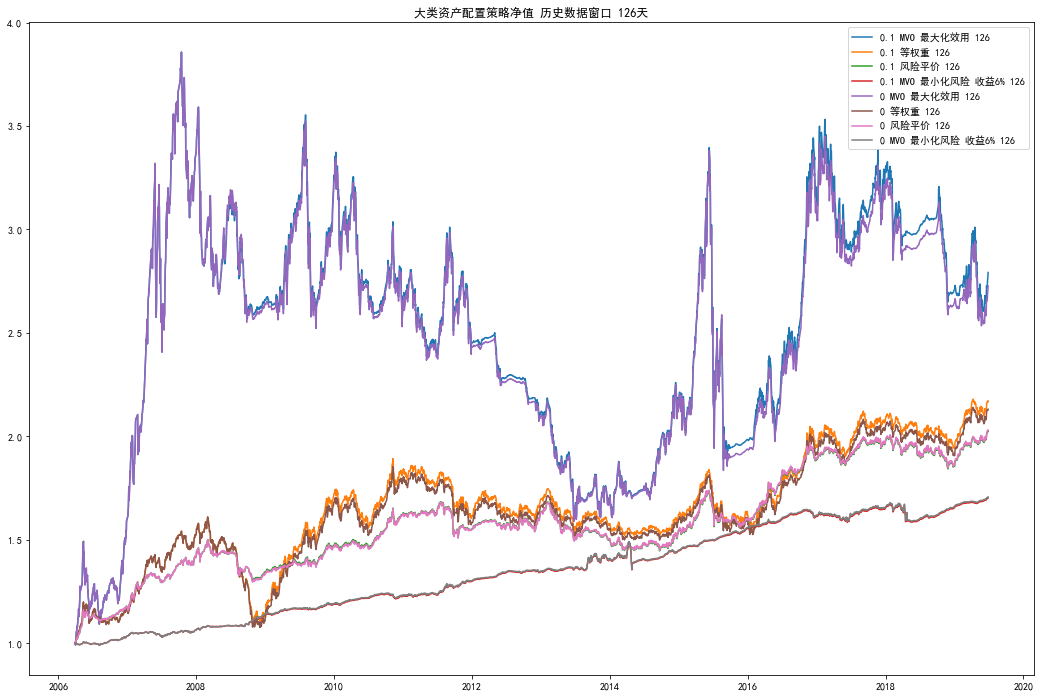

In [126]:
# 超额净值
for window in WindowList:
    plt.figure(figsize=(18,12))
    plt.title('大类资产配置策略净值 历史数据窗口 %s天' %(window))
    for key in EquitySeriesDict.keys():
        if key[-3:] == str(window):
            plt.plot(EquitySeriesDict[key]['equity_series'],label=key)
        if key[-2:] == str(window):
            plt.plot(EquitySeriesDict[key]['equity_series'],label=key)
    plt.legend(loc=0)
    plt.show()

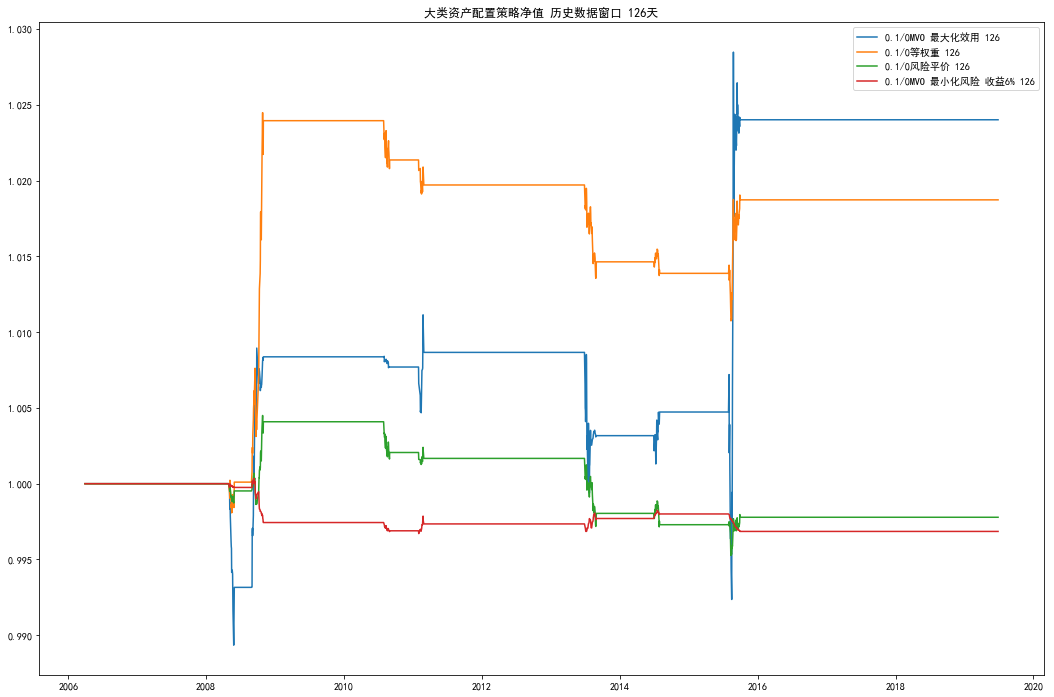

In [127]:
# 超额净值
for window in WindowList:
    plt.figure(figsize=(18,12))
    for method in WeightGetList:
        name_1 = str(MinPositionList[0])+' '+method+' '+str(window)
        name_2 = str(MinPositionList[1])+' '+method+' '+str(window)
        plt.plot(EquitySeriesDict[name_1]['equity_series']/EquitySeriesDict[name_2]['equity_series'],label=str(MinPositionList[0])+'/'+str(MinPositionList[1])+method+' '+str(window))
        plt.title('大类资产配置策略净值 历史数据窗口 %s天' %(window))
    plt.legend(loc=0)
    plt.show()

In [128]:
benchmarkDf = pd.DataFrame()
for col in AssetList:
    benchmarkDfEach = Indicator(AssetPrice[AssetPrice.index>='2006-02-28'][[col]])[0]
    benchmarkDfEach.columns = [col]
    benchmarkDf = pd.concat([benchmarkDf,benchmarkDfEach.T],axis=0)
benchmarkDf

,mean_return,vol_return,IR,sharpe_ratio,max_drawdown,mean_return_max_drawdown_ratio
中证500,0.179268,0.321617,0.557396,0.464118,0.724172,0.247549
沪深300,0.140127,0.281882,0.497113,0.390685,0.723038,0.193803
上证国债,0.035268,0.009847,3.581582,0.534994,0.022502,1.567353
南华能化指数,0.021133,0.208669,0.101273,-0.042496,0.615426,0.034338
南华金属指数,0.063357,0.214514,0.295352,0.155501,0.619762,0.102228
南华农产品指数,-0.004414,0.121756,-0.036249,-0.282644,0.384495,-0.011479
南华工业品指数,0.040310,0.193673,0.208137,0.053236,0.603409,0.066804
中证企业债,0.045096,0.036359,1.240305,0.415198,0.096232,0.468621
中证金融债,0.039799,0.017790,2.237073,0.550776,0.045366,0.877280
SGE黄金9999,0.075484,0.170312,0.443211,0.267063,0.448841,0.168175
